# CSE 6240 Project 2 LSTMs for Language Detection

Yang Wu, Xianghui Gu

GT username: ywu613, xgu72

GTid: 903248393, 903248583

## PART I: Building String Scoring Models Using LSTM

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
import numpy as np
import random
import sys

Using TensorFlow backend.


### Read file

In [2]:
def read_file(file_name):
    text_file = open("data/"+file_name, "r")
    lines = text_file.read().lower()
    text_file.close()
    return lines

In [3]:
eng_text = read_file("eng.txt")

In [4]:
eng_chars = sorted(list(set(eng_text)))
print('eng_chars:', len(eng_chars))

eng_chars: 43


In [5]:
frn_text = read_file("frn.txt")

In [6]:
frn_chars = sorted(list(set(frn_text)))
print('frn_chars:', len(frn_chars))

frn_chars: 41


### Count chars and create char index dict

In [7]:
chars = sorted(list((set(eng_text)|set(frn_text))))

In [8]:
print('total chars:', len(chars))

total chars: 44


In [9]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

### Vectorize text

In [10]:
maxlen = 5

In [11]:
# cut the text in semi-redundant sequences of maxlen characters
def cut(text, maxlen = 5, step = 1):
    sentences = []
    next_chars = []
    for i in range(0, len(text) - maxlen, step):
        sentences.append(text[i: i + maxlen])
        next_chars.append(text[i + maxlen])
    print('nb sequences:', len(sentences),' with maxlen of ', maxlen, ' and step of ', step)
    return (sentences, next_chars)


In [12]:
eng_sen, eng_next_chars = cut(eng_text)

nb sequences: 10741  with maxlen of  5  and step of  1


In [13]:
frn_sen, frn_next_chars = cut(frn_text)

nb sequences: 12004  with maxlen of  5  and step of  1


In [14]:
def vectorize(sentences, next_chars, chars, char_indices, maxlen = 5):
#     print('Vectorization...')
    X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
    y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
    for i, sentence in enumerate(sentences):
        for t, char in enumerate(sentence):
            X[i, t, char_indices[char]] = 1
            y[i, char_indices[next_chars[i]]] = 1
    return (X,y)

In [15]:
eng_X, eng_y = vectorize(eng_sen, eng_next_chars, chars, char_indices)
frn_X, frn_y = vectorize(frn_sen, frn_next_chars, chars, char_indices)

### Split data

In [16]:
from sklearn.model_selection import train_test_split
eng_X_train, eng_X_test, eng_y_train, eng_y_test = train_test_split(eng_X, 
                                                                     eng_y , 
                                                                     test_size=0.2, 
                                                                     random_state=0)
frn_X_train, frn_X_test, frn_y_train, frn_y_test = train_test_split(frn_X, 
                                                                     frn_y , 
                                                                     test_size=0.2, 
                                                                     random_state=0)

In [17]:
eng_index = np.random.choice(range(len(eng_X_test)), 100, replace=False)
frn_index = np.random.choice(range(len(frn_X_test)), 100, replace=False)

X_test = np.concatenate((eng_X_test[eng_index, :], frn_X_test[frn_index, :]), axis=0)
y_test = np.array([1]*100+[0]*100)

In [18]:
print(X_test.shape, y_test.shape)

(200, 5, 44) (200,)


### Build LSTM model

Train English model

In [19]:
# build the model: a single LSTM
print('Build eng_model...')
maxlen = 5
eng_model = Sequential()
eng_model.add(LSTM(128, input_shape=(maxlen, len(chars))))
eng_model.add(Dense(len(chars)))
eng_model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
eng_model.compile(loss='categorical_crossentropy', optimizer=optimizer)


Build eng_model...


In [20]:
eng_history = eng_model.fit(eng_X_train, eng_y_train, batch_size=128, epochs = 5)

Epoch 1/5
8592/8592 [==============================] - 2s - loss: 2.6445     
Epoch 2/5
8592/8592 [==============================] - 2s - loss: 2.0326     
Epoch 3/5
8592/8592 [==============================] - 2s - loss: 1.7657     
Epoch 4/5
8592/8592 [==============================] - 2s - loss: 1.5621     
Epoch 5/5
8592/8592 [==============================] - 1s - loss: 1.3899     


In [21]:
eng_model.evaluate(eng_X_test,eng_y_test,batch_size = 128)

2048/2149 [===========================>..] - ETA: 0s

1.6710525247983015

Train french model

In [22]:
# build the model: a single LSTM
print('Build frn_model...')
maxlen = 5
frn_model = Sequential()
frn_model.add(LSTM(128, input_shape=(maxlen, len(chars))))
frn_model.add(Dense(len(chars)))
frn_model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
frn_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Build frn_model...


In [23]:
frn_history = frn_model.fit(frn_X_train, frn_y_train, batch_size=128, epochs = 5)

Epoch 1/5
9603/9603 [==============================] - 3s - loss: 2.5195     
Epoch 2/5
9603/9603 [==============================] - 2s - loss: 1.9811     
Epoch 3/5
9603/9603 [==============================] - 2s - loss: 1.7501     
Epoch 4/5
9603/9603 [==============================] - 2s - loss: 1.5815     
Epoch 5/5
9603/9603 [==============================] - 2s - loss: 1.4207     


In [24]:
frn_model.evaluate(frn_X_test,frn_y_test,batch_size = 128)

2401/2401 [==============================] - 0s     


1.8182850280239005

### Language Detection

In [25]:
import math

In [26]:
models = [eng_model, frn_model]

In [27]:
def detect(X_test, models, char_indices, indices_char, maxlen = 5):
    num_test = len(X_test) ## number of tests
    num_model = len(models) ## number of models
    num_chars = len(indices_char) ## number of chars in dict
    results = []
    for test in range(num_test):
        result = []
        X = X_test[test,:,:]     
        for model in models:
            start = np.zeros((1, maxlen, num_chars))
            ans = 0
            for l in range(maxlen):
                next_char = X[l,:]
                next_ind = np.where(next_char > 0)[0][0]
                output_vector = model.predict(start)
                prob_char = output_vector[:,next_ind][0]
                ans += np.log(prob_char)
                start[:,:(maxlen-1),:] = start[:,1:,:]
                start[:,maxlen - 1, :] = next_char                
            result.append(ans)
        results.append(result)
    return results

In [28]:
lang_detect = np.array(detect(X_test, models, char_indices, indices_char, maxlen = 5))

In [29]:
yhat = lang_detect[:,0] - lang_detect[:,1]

In [30]:
from sklearn.metrics import *
roc_auc = roc_auc_score(y_test,yhat)

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, yhat)

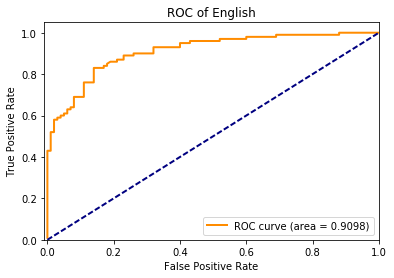

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0., 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of English')
plt.legend(loc="lower right")
plt.show()

## Questions
### Is this model good?

Yes. From the ROC curve, the model is a good choice for language detection.

### What are at least three alternatives to language detection that you can think of or find on the internet? What are the pros and cons of each approach?

#### 1. Naive Bayes

- Pros: robust, easy to implement, fast, and accurate. 
- Cons: strong violations of the independence assumptions can lead to very poor performances of naive Bayes classifiers.

#### 2. N-grams. 

- Pros: simple, can capture the inherent structure in each language. For example, in English, it's very common for the letter 'u' to follow the letter 'q,' while this is not the case in transliterated Arabic.
- Cons: lack explicit representation of long range dependency.

#### 3. Markov Models

- Pros: take into account not only the appearing frequency, but also some sequence information.
- Cons: need conditional independent assumption.


Reference

[1] Wikipedia - N-grams, Markov Model

[2] Padró, Muntsa, and Lluıs Padró. "Comparing methods for language identification." Procesamiento del lenguaje natural 33 (2004): 155-162.

[3] Rao, K. Sreenivasa, and Dipanjan Nandi. "Language Identification—A Brief Review." Language Identification Using Excitation Source Features. Springer International Publishing, 2015. 11-30.

### Briefly describe at least 5 ways that you can improve this model, and what you think the value and predicted result of each approach would be?

1. Larger maxlen. This might improve the accuracy. In the next part, we will change maxlen to 10, and the result supports our conclusion.
2. More epochs. This might improve the accuracy.
3. Change the learning rate. This may affect the converge time, and let us train model faster.
4. More neurons per layer. Might need more time to train, but achieve higher accuracy.
5. Use GPUs for training. Because it is not a larger dataset, this may have a little influence on the efficiency.

## PART II: Further study - Extra Credit
### 1. Use all the testing data to test the models

In [33]:
X_test_full = np.concatenate((eng_X_test, frn_X_test), axis=0)
y_test_full = np.array([1]*len(eng_X_test)+[0]*len(frn_X_test))

In [34]:
X_test_full.shape

(4550, 5, 44)

In [35]:
y_test_full.shape

(4550,)

In [36]:
lang_detect = np.array(detect(X_test_full, models, char_indices, indices_char, maxlen = 5))

In [37]:
yhat = lang_detect[:,0] - lang_detect[:,1]

In [38]:
from sklearn.metrics import *
roc_auc = roc_auc_score(y_test_full,yhat)
fpr, tpr, thresholds = roc_curve(y_test_full, yhat)

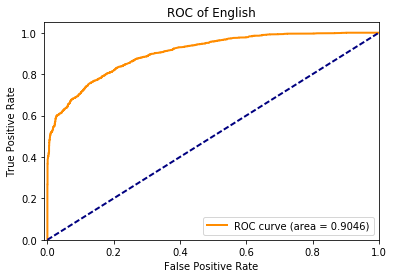

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0., 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of English')
plt.legend(loc="lower right")
plt.show()

As can be seen from the figure, the ROC is slightly lower than the test subset. But the graph is much smoother.

### 2. Modify maxlen

for further use, we encapsulate the model training into a function.

In [40]:
def train_model(X_train, y_train, maxlen, chars, learning_rate = 0.01, batch_size = 128, epochs = 5):
    model = Sequential()
    model.add(LSTM(128, input_shape=(maxlen, len(chars))))
    model.add(Dense(len(chars)))
    model.add(Activation('softmax'))
    optimizer = RMSprop(lr=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)
    model.fit(X_train, y_train, batch_size=batch_size, epochs = epochs)
    return model

In [41]:
from sklearn.metrics import *
import matplotlib.pyplot as plt
def plot_roc(y_test, yhat, title):
    roc_auc = roc_auc_score(y_test,yhat)
    fpr, tpr, thresholds = roc_curve(y_test, yhat)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0., 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC of ' + title)
    plt.legend(loc="lower right")
    plt.show()

Next, we set maxlen to 10 and split the sentence.

In [42]:
eng_sen, eng_next_chars = cut(eng_text, 10)
frn_sen, frn_next_chars = cut(frn_text, 10)

nb sequences: 10736  with maxlen of  10  and step of  1
nb sequences: 11999  with maxlen of  10  and step of  1


In [43]:
eng_X, eng_y = vectorize(eng_sen, eng_next_chars, chars, char_indices, 10)
frn_X, frn_y = vectorize(frn_sen, frn_next_chars, chars, char_indices, 10)

In [44]:
eng_X_train, eng_X_test, eng_y_train, eng_y_test = train_test_split(eng_X, 
                                                                     eng_y , 
                                                                     test_size=0.2, 
                                                                     random_state=0)
frn_X_train, frn_X_test, frn_y_train, frn_y_test = train_test_split(frn_X, 
                                                                     frn_y , 
                                                                     test_size=0.2, 
                                                                     random_state=0)

In [45]:
eng_index = np.random.choice(range(len(eng_X_test)), 100, replace=False)
frn_index = np.random.choice(range(len(frn_X_test)), 100, replace=False)

X_test = np.concatenate((eng_X_test[eng_index, :], frn_X_test[frn_index, :]), axis=0)
y_test = np.array([1]*100+[0]*100)

In [46]:
eng_model = train_model(eng_X_train, eng_y_train, 10, chars)

Epoch 1/5
8588/8588 [==============================] - 4s - loss: 2.9487     
Epoch 2/5
8588/8588 [==============================] - 3s - loss: 2.3657     
Epoch 3/5
8588/8588 [==============================] - 4s - loss: 2.0546     
Epoch 4/5
8588/8588 [==============================] - 3s - loss: 1.8183     
Epoch 5/5
8588/8588 [==============================] - 3s - loss: 1.6331     


In [47]:
frn_model = train_model(frn_X_train, frn_y_train, 10, chars)

Epoch 1/5
9599/9599 [==============================] - 5s - loss: 2.7151     
Epoch 2/5
9599/9599 [==============================] - 4s - loss: 2.1595     
Epoch 3/5
9599/9599 [==============================] - 4s - loss: 1.9054     
Epoch 4/5
9599/9599 [==============================] - 4s - loss: 1.7116     
Epoch 5/5
9599/9599 [==============================] - 4s - loss: 1.5566     


In [48]:
models = [eng_model, frn_model]

In [49]:
lang_detect = np.array(detect(X_test, models, char_indices, indices_char, 10))

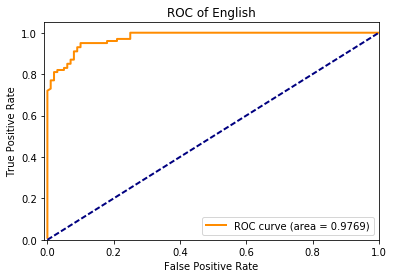

In [50]:
yhat = lang_detect[:,0] - lang_detect[:,1]
plot_roc(y_test,yhat,'English')

As we can see, the ROC is much higher than the case where max_len = 5. It might reflect that the mean length of words in the sample is longer than 5 letters. As can be seen from the text, the sample text uses a lot of fancy, long words.

### 3. Add Language - Latin

Some languages are easy to detect since they have very different letters. From the selected languages, we decide to use Latin since its alphabet has a large overlap with English and French. To distinguish three languages better, here we set maxlen = 10.

In [51]:
ltn_text = read_file("ltn.txt")

In [52]:
ltn_chars = sorted(list(set(ltn_text)))

In [53]:
chars = sorted(list((set(eng_text)|set(frn_text)|set(ltn_text))))

In [54]:
print('total chars:', len(chars))

total chars: 45


In [55]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [56]:
ltn_sen, ltn_next_chars = cut(frn_text, 10)

nb sequences: 11999  with maxlen of  10  and step of  1


In [57]:
eng_X, eng_y = vectorize(eng_sen, eng_next_chars, chars, char_indices, 10)
frn_X, frn_y = vectorize(frn_sen, frn_next_chars, chars, char_indices, 10)
ltn_X, ltn_y = vectorize(ltn_sen, ltn_next_chars, chars, char_indices, 10)

In [58]:
eng_X_train, eng_X_test, eng_y_train, eng_y_test = train_test_split(eng_X, 
                                                                     eng_y , 
                                                                     test_size=0.2, 
                                                                     random_state=0)
frn_X_train, frn_X_test, frn_y_train, frn_y_test = train_test_split(frn_X, 
                                                                     frn_y , 
                                                                     test_size=0.2, 
                                                                     random_state=0)
ltn_X_train, ltn_X_test, ltn_y_train, ltn_y_test = train_test_split(ltn_X, 
                                                                     ltn_y , 
                                                                     test_size=0.2, 
                                                                     random_state=0)

In [59]:
eng_index = np.random.choice(range(len(eng_X_test)), 100, replace=False)
frn_index = np.random.choice(range(len(frn_X_test)), 100, replace=False)
ltn_index = np.random.choice(range(len(ltn_X_test)), 100, replace=False)

X_test = np.concatenate((eng_X_test[eng_index, :], frn_X_test[frn_index, :], ltn_X_test[ltn_index, :]), axis=0)
y_test = np.array([0]*100+[1]*100+[2]*100)

In [60]:
eng_model = train_model(eng_X_train, eng_y_train, 10, chars)

Epoch 1/5
8588/8588 [==============================] - 4s - loss: 2.7899     
Epoch 2/5
8588/8588 [==============================] - 3s - loss: 2.1456     
Epoch 3/5
8588/8588 [==============================] - 4s - loss: 1.8411     
Epoch 4/5
8588/8588 [==============================] - 3s - loss: 1.6082     
Epoch 5/5
8588/8588 [==============================] - 4s - loss: 1.4188     


In [61]:
frn_model = train_model(frn_X_train, frn_y_train, 10, chars)

Epoch 1/5
9599/9599 [==============================] - 4s - loss: 2.5980     
Epoch 2/5
9599/9599 [==============================] - 4s - loss: 2.0279     
Epoch 3/5
9599/9599 [==============================] - 4s - loss: 1.7505     
Epoch 4/5
9599/9599 [==============================] - 4s - loss: 1.5546     
Epoch 5/5
9599/9599 [==============================] - 4s - loss: 1.3753     


In [62]:
ltn_model = train_model(ltn_X_train, ltn_y_train, 10, chars)

Epoch 1/5
9599/9599 [==============================] - 4s - loss: 2.8122     
Epoch 2/5
9599/9599 [==============================] - 4s - loss: 2.2743     
Epoch 3/5
9599/9599 [==============================] - 4s - loss: 1.9779     
Epoch 4/5
9599/9599 [==============================] - 4s - loss: 1.7621     
Epoch 5/5
9599/9599 [==============================] - 4s - loss: 1.5927     


In [63]:
models = [eng_model, frn_model, ltn_model]

In [64]:
lang_detect = np.array(detect(X_test, models, char_indices, indices_char, 10))

In [65]:
pred_result = np.argmax(lang_detect,axis = 1)

In [66]:
accuracy_score(y_test, pred_result)

0.59999999999999998

The accuracy is satisfactory for three similar languages.

In [67]:
pred_result

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1,
       1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1,
       2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 0,
       1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2,
       1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1,
       1])

It can be seen from the predicted categories, Latin can be easily prediced to be French and sometimes English. French uses a lof of Latin vocabulary and English borrows many words from French.